In [90]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [91]:
model_path = './runs/train/MEL_128x128_scratch/weights/best.pt'

In [140]:
model = torch.hub.load('../yolov5', 'custom', path=model_path, source='local')  # local model

model.conf = 0.4  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
      #agnostic = False  # NMS class-agnostic
      #multi_label = False  # NMS multiple labels per box
      #classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
      #max_det = 1000  # maximum number of detections per image
      #amp = False  # Automatic Mixed Precision (AMP) inference

YOLOv5 🚀 2022-10-29 Python-3.9.12 torch-1.12.1 CPU

Fusing layers... 
YOLOv5m summary: 212 layers, 20856975 parameters, 0 gradients
Adding AutoShape... 


In [151]:
state_dict = torch.load(model_path) # custom state dict model.load_state_dict(state_dict['model_state'])

In [162]:
#state_dict['model']

In [165]:
#model.model.model.model[-2]

In [169]:
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 11.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5247 sha256=2ec3d6f2ee972cd2b3c720730374c3375b0f91d7c0816835cc46350bc9362b5a
  Stored in directory: /Users/deliaahmed/Library/Caches/pip/wheels/dd/3c/0e/8b7512f5d7f462c9c37342107b7f0276609345f246ae4e75fc
Successfully built pytorch-gradcam


In [170]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


#image_url = "https://upload.wikimedia.org/wikipedia/commons/f/f1/Puppies_%284984818141%29.jpg"
#img = np.array(Image.open(requests.get(image_url, stream=True).raw))
im_ex = '../Detect_Set3/1156.png'
img = np.array(Image.open(im_ex))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

#model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model = torch.hub.load('../yolov5', 'custom', path=model_path, source='local', pretrained=True)  # local model
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

ModuleNotFoundError: No module named 'pytorch_grad_cam'

image 1/1: 128x128 1 Nonmitosis
Speed: 101.8ms pre-process, 69.8ms inference, 328.8ms NMS per image at shape (1, 3, 128, 128)
        xmin       ymin       xmax        ymax  confidence  class        name
0  17.577463  59.260811  73.891174  115.613487    0.545145      0  Nonmitosis


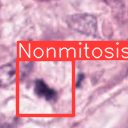

In [93]:
im_ex = '../Detect_Set3/1156.png'
results = model(im_ex, size=128)  # inference; results = model([im1, im2], size=640) # batch of images
print(results)
print(results.pandas().xyxy[0]) # Pandas DataFrame
results.show()  # or .save()

In [94]:
model.eval();

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [109]:
model1 = torch.load(model_path)

In [95]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

#img = Image.open('../model_dev/Data_CMC_COADEL_64_1/val/Nonmitosis/10002.jpg')
img = Image.open(im_ex)
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [98]:
input = input.to(device)
output = model(input) #.to(device)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = str(pred_label_idx.item())
print(output)
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

ValueError: only one element tensors can be converted to Python scalars

In [108]:
torch.topk(output,1)[0]

tensor([[[0.00034],
         [0.00034],
         [0.00033],
         ...,
         [0.01980],
         [0.00800],
         [0.02509]]])

In [133]:
def wrapper(input):
    return torch.sum(model(input), axis = (2, 3))

In [134]:
from captum.attr import IntegratedGradients

In [135]:
ig = IntegratedGradients(wrapper)
attribution_A = ig.attribute(img.unsqueeze(0),target=0) 
attribution_B = ig.attribute(img.unsqueeze(0),target=1) 

AttributeError: unsqueeze

In [137]:
img.unsqueeze(0)

AttributeError: unsqueeze